# Feedforward Neural Network with PyTorch for the MNIST dataset

Probably, you need GPUs for this notebook

## Packages

In [30]:
#!pip install torch==2.4 # Run just once
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim

## Dataset
First, we load the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) directly from PyTorch, then we inspect it, as well as its elements

We have  60000 train samples
We have  10000 validation/test samples
Type of these elements: <class 'torchvision.datasets.mnist.MNIST'> <class 'torchvision.datasets.mnist.MNIST'>


An example: 


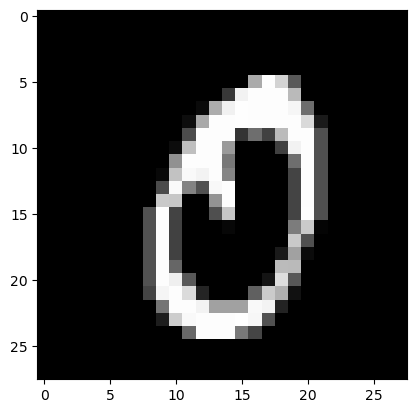

In [31]:
dataset_train = datasets.MNIST('.', train=True, download=True, transform=transforms.ToTensor()) # download = True just once
dataset_test = datasets.MNIST('.', train=False, download=True, transform=transforms.ToTensor())

print("We have ", len(dataset_train), "train samples")
print("We have ", len(dataset_test), "validation/test samples")

print("Type of these elements:", type(dataset_train), type(dataset_test))

print("\n")

# Get an item and its class
k = torch.randint(1, len(dataset_train), (1,))
k = int(k)
X, y = dataset_train[k]

# Show just one item
print("An example: ")
plt.imshow(X.squeeze(), cmap="gray")
plt.show()

**Question**: what happens if you remove the `squeeze` function?

Now we perform what we called `dataset_test` in validation and test

In [32]:
dataset_validation, dataset_test = torch.utils.data.random_split(dataset_test, [0.5, 0.5])
print("We have", len(dataset_validation), "items for validation and", len(dataset_test), "items for test")

We have 5000 items for validation and 5000 items for test


We are ready now for the dataloaders

In [33]:
batch_size = 64 # Reduce it in case you need it

train_loader = DataLoader(dataset_train, batch_size=batch_size)
validation_loader = DataLoader(dataset_validation, batch_size=len(dataset_validation))
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test))

## Model

in this part, we want to define the model. In our case, we want to have 2 hidden layers. Input and output dimensions are given by the problem

In [34]:
class Model(nn.Module):
    def __init__(self, input_size, d_1, d_2, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, d_1)
        self.fc2 = nn.Linear(d_1, d_2)
        self.fc3 = nn.Linear(d_2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# Hyperparameters
d_1 = 100
d_2 = 50
model = Model(28*28, d_1, d_2, 10)

In [35]:
print(model)

Model(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


**Question** : After printing the form, you may have noticed that something is missing. What is it?

Yu can print the model weights -- remember that, at the very beginning these are not trained

In [36]:
for key, value in model.state_dict().items():
    print(key, value)

fc1.weight tensor([[-0.0171, -0.0059,  0.0211,  ...,  0.0066,  0.0218,  0.0320],
        [-0.0097,  0.0061,  0.0086,  ..., -0.0219,  0.0016,  0.0024],
        [-0.0020, -0.0118, -0.0289,  ...,  0.0098,  0.0192, -0.0339],
        ...,
        [-0.0221, -0.0249,  0.0184,  ..., -0.0091, -0.0050, -0.0126],
        [ 0.0128,  0.0185, -0.0076,  ...,  0.0300,  0.0170, -0.0210],
        [ 0.0356,  0.0032,  0.0068,  ..., -0.0272,  0.0310, -0.0262]])
fc1.bias tensor([-1.2159e-02, -3.0037e-02,  3.3552e-02, -1.8436e-02,  1.1016e-02,
        -3.1194e-02,  1.9492e-02,  4.8242e-03,  2.0827e-02,  2.9838e-02,
         1.6806e-02,  3.0876e-02,  3.1822e-02, -2.9825e-02, -7.3102e-03,
         9.1264e-03,  1.2367e-02, -4.9669e-03, -3.4223e-02, -1.5726e-02,
         1.1198e-02, -2.6960e-02,  1.0202e-02, -2.9426e-02,  1.5221e-02,
        -2.0187e-02,  2.0896e-02, -2.5410e-02,  1.6973e-02,  6.2477e-03,
         3.4349e-02,  3.2659e-02, -1.9575e-02,  2.1334e-05, -1.2080e-02,
         2.9410e-02, -8.7671e-03, -

## Training loop

First, we define Loss and Optimizer

In [37]:
# Hyperparameter!
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

Then, we decide which device we want to use

In [38]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

Working on mps


Lastly, we set a number of epochs and perform standard training loop

In [39]:
n_epochs = 5
train_loss_list = []
validation_loss_list = []
for epoch in range(n_epochs):
    for data, target in train_loader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # You have to flatten the data!
        data = data.reshape(-1,28*28)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
        
    train_loss = loss.item()
    train_loss_list.append(train_loss)
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validation_loader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
             # You have to flatten the data!
            data = data.reshape(-1,28*28)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {train_loss}, Validation loss {validation_loss}")
            validation_loss_list.append(validation_loss)
    

/Users/stefano/miniconda3/envs/DeepL/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (10) must match the size of tensor b (64) at non-singleton dimension 1

**Questions**: 
1. Try to use and not use GPUs: is there any difference?
2. Are we cheating somewher in computing the loss values?
3. Try to play a little bit with the learning rate, using values such as 0.05 or even 0.1. What can you observe?

We do a simple plot of the two loss functions

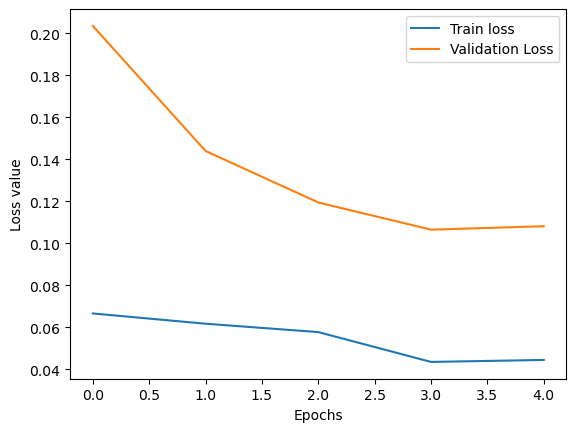

In [24]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

## Test

In this section, we test our model on new data by computing the accuracy

In [25]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        # You have to flatten the data!
        data = data.reshape(-1,28*28)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 96.78 %


## Save & Load models

In [26]:
state = {
    'model_state' : model.state_dict(),
    'optimizer' : optimizer.state_dict()
}
torch.save(state, 'Models/model_04.pt')

In [27]:
model = Model(28*28, d_1, d_2, 10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
checkpoint = torch.load("Models/model_04.pt", weights_only=True)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optimizer'])

You loaded a trained model, so it should make good preditcions, let's see

Here we want to predict digit  6


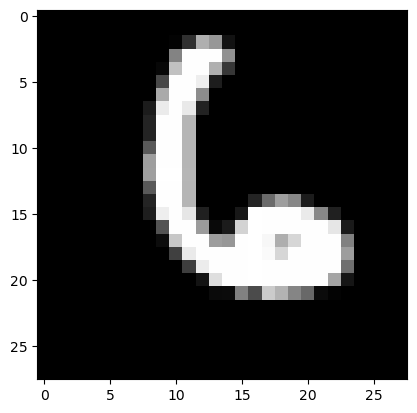


 We predicted tensor([6])


In [28]:
k = torch.randint(1, len(dataset_test), (1,))
k = int(k)
X, y = dataset_test[k]

# Show just one item
print("Here we want to predict digit ", y)
plt.imshow(X.squeeze(), cmap="gray")
plt.show()

data = X.reshape(-1,28*28)
outputs = model(data)
_, predicted = torch.max(outputs.data, 1)

print("\n We predicted", predicted)

# Training loop with Neptune*

This section is more advanced, and we recomment dive into it only if you plan to use Neptune

In [29]:
#!pip install neptune
import neptune

# Replace empty strings with your values
run = neptune.init_run(
    project="",
    api_token="",
) 

params = {"learning_rate": learning_rate, "optimizer": "Adam"}
run["parameters"] = params

# Re initialize the optimizer, model and loss function
model = Model(28*28, d_1, d_2, 10)
model.to(DEVICE)

# Hyperparameter!
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


n_epochs = 10
for epoch in range(n_epochs):
    for data, target in train_loader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # You have to flatten the data!
        data = data.reshape(-1,28*28)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
        
    train_loss = loss.item()
    run["train/loss_train"].append(train_loss)
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validation_loader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
             # You have to flatten the data!
            data = data.reshape(-1,28*28)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {train_loss}, Validation loss {validation_loss}")
            run["train/loss_eval"].append(validation_loss)
    
run.stop()

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


NeptuneInvalidApiTokenException: 
[95m
----NeptuneInvalidApiTokenException------------------------------------------------
[0m
The provided API token is invalid.
Make sure you copied and provided your API token correctly.

You can get it or check if it is correct here:
    - https://app.neptune.ai/get_my_api_token

There are two options to add it:
    - specify it in your code
    - set it as an environment variable in your operating system.

[94mCODE[0m
Pass the token to the [1minit_run()[0m function via the [1mapi_token[0m argument:
    [96mneptune.init_run(project='WORKSPACE_NAME/PROJECT_NAME', api_token='YOUR_API_TOKEN')[0m

[94mENVIRONMENT VARIABLE[0m [92m(Recommended option)[0m
or export or set an environment variable depending on your operating system:

    [92mLinux/Unix[0m
    In your terminal run:
        [95mexport NEPTUNE_API_TOKEN="YOUR_API_TOKEN"[0m

    [92mWindows[0m
    In your CMD run:
        [95mset NEPTUNE_API_TOKEN="YOUR_API_TOKEN"[0m

and skip the [1mapi_token[0m argument of the [1minit_run()[0m function:
    [96mneptune.init_run(project='WORKSPACE_NAME/PROJECT_NAME')[0m

You may also want to check the following docs page:
    - https://docs.neptune.ai/setup/setting_api_token/

[92mNeed help?[0m-> https://docs.neptune.ai/getting_help


**Question**: Do we really need to initialize everything from scratch?